<a href="https://colab.research.google.com/github/Nckflannery/DS-Unit-2-Regression-Classification/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


#Import

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 4.6MB/s 


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Train/val/test split

In [4]:
my_train, my_val = train_test_split(train)
my_train.shape, my_val.shape

((44550, 41), (14850, 41))

# Feature engineering

## Copy

In [0]:
# Let's create a copy of the train data set to do some feature engineering tests
# to explore and build code for our function later (we'll name it x to match up
# with our function so we can easily copy paste bits we like)
x = train.copy()

In [0]:
# Let's cat code the status_group so we can use .corr() to look at some of the
# numeric features' correlations
x['functionality'] = x['status_group'].astype('category').cat.codes

In [257]:
x['functionality'].value_counts()

0    32259
2    22824
1     4317
Name: functionality, dtype: int64

In [258]:
x['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [259]:
# This will be more usefull later when we cat code some of the other features
x.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,functionality
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082,0.004049
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,-0.053702
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,-0.114029
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732,0.004366
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,-0.014547
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,-0.005021
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,0.108640
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,0.065687
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,-0.017759
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,-0.043342


## Time from construction to inspection

In [377]:
# Replace date_recorded with an int of just the year
x['date_recorded'] = x['date_recorded'].str[:4].astype(int)
x['date_recorded'].value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

In [378]:
# May have an issue with having many 0's in construction_year we can deal with 
# it later in the new feature
x['construction_year'].value_counts()[:5]

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
Name: construction_year, dtype: int64

In [379]:
x['years_before_service'] = x['date_recorded'] - x['construction_year']
x['years_before_service'].value_counts()

 2011    13343
 2012     5142
 3        2740
 1        2303
 2013     2210
 2        2129
 5        1980
 4        1890
 13       1869
 7        1404
 6        1381
 11       1352
 8        1160
 14       1160
 33       1120
 15        993
 23        905
 10        868
 16        826
 9         814
 19        766
 27        762
 18        754
 31        709
 28        709
 35        647
 17        636
 39        601
 37        600
 26        589
         ...  
 20        541
 41        488
 30        359
 43        356
 38        351
 36        325
 22        323
 24        261
 40        233
 34        184
 32        174
 53         91
 42         90
 50         84
 45         66
 46         48
 44         47
 48         41
 51         31
 49         25
 47         14
 2004       13
 52         11
-5           3
-4           2
-1           1
-3           1
-2           1
 2002        1
-7           1
Name: years_before_service, Length: 65, dtype: int64

In [380]:
# Negatives???? Something isn't right!
x[['date_recorded', 'construction_year', 'years_before_service']][x['years_before_service']<0]

,date_recorded,construction_year,years_before_service
8729,2004,2008,-4
10441,2004,2006,-2
13366,2004,2011,-7
23373,2004,2009,-5
27501,2004,2009,-5
32619,2004,2005,-1
33942,2004,2007,-3
39559,2004,2009,-5
48555,2004,2008,-4


In [381]:
# Dealing with our 0s from earlier
x[['date_recorded', 'construction_year', 'years_before_service']][x['years_before_service']>100]

,date_recorded,construction_year,years_before_service
4,2011,0,2011
6,2012,0,2012
7,2012,0,2012
8,2012,0,2012
9,2011,0,2011
12,2012,0,2012
14,2012,0,2012
21,2013,0,2013
27,2011,0,2011
30,2011,0,2011


In [0]:
# Either someone is collecting data poorly or someone is trying to look good!
# Let's replace all values that are missing with 0
x.loc[(x['years_before_service']<0) | (x['years_before_service']>100), 'years_before_service'] = 0

In [383]:
x['years_before_service'].value_counts()

0     21306
3      2740
1      2303
2      2129
5      1980
4      1890
13     1869
7      1404
6      1381
11     1352
8      1160
14     1160
33     1120
15      993
23      905
10      868
16      826
9       814
19      766
27      762
18      754
31      709
28      709
35      647
17      636
39      601
37      600
26      589
25      583
21      578
29      564
12      559
20      541
41      488
30      359
43      356
38      351
36      325
22      323
24      261
40      233
34      184
32      174
53       91
42       90
50       84
45       66
46       48
44       47
48       41
51       31
49       25
47       14
52       11
Name: years_before_service, dtype: int64

## Deal with None, none, 0   (RUN AFTER HIGH CARDINALITY)

In [360]:
x.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]

,count,unique,top,freq
region,59400,21,Iringa,5294
extraction_type,59400,18,gravity,26780
extraction_type_group,59400,13,gravity,26780
management,59400,12,vwc,40507
scheme_management,55523,12,VWC,36793
funder,59400,11,Other,36967
wpt_name,59400,11,Other,51209
subvillage,59400,11,Other,56342
lga,59400,11,Other,46930
ward,59400,11,Other,57168


In [60]:
# Let's look at some of these features
x['scheme_name'].value_counts()[:10]

K                              682
None                           644
Borehole                       546
Chalinze wate                  405
M                              400
DANIDA                         379
Government                     320
Ngana water supplied scheme    270
wanging'ombe water supply s    261
wanging'ombe supply scheme     234
Name: scheme_name, dtype: int64

In [61]:
x['installer'].value_counts()[:10]

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
Name: installer, dtype: int64

In [68]:
x['funder'].value_counts()[:15]

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Name: funder, dtype: int64

In [70]:
x['wpt_name'].value_counts()[:5]

none         3563
Shuleni      1748
Zahanati      830
Msikitini     535
Kanisani      323
Name: wpt_name, dtype: int64

In [0]:
# Replace None, none, 0 with NaN values, and fix long/lat columns
features_replace = ['scheme_name', 'installer', 'funder', 'wpt_name', 'longitude', 'latitude']
x[features_replace] = x[features_replace].replace({'None':np.nan, 'none':np.nan, '0':np.nan, -2e-8:np.nan})

In [362]:
x['latitude'].isnull().sum()

1812

## High Cardinality

In [384]:
# Creat a dataframe from our top 10 features by unique values
df = x.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]
high_card = 50
# Use this to create a list of features that are of high cardinality
high_card_features = df[df['unique'] >= high_card].T.columns.tolist()
# List of high cardinality features
high_card_features

['wpt_name', 'subvillage', 'scheme_name', 'installer', 'ward', 'funder', 'lga']

#### Let's make sure this will work in our function for the test or val since they will have different levels of cardinality!

In [198]:
test.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]

,count,unique,top,freq
wpt_name,14358,10615,none,822
subvillage,14264,8253,Shuleni,136
ward,14358,1934,Igosi,79
scheme_name,7519,1772,Borehole,158
installer,13570,1075,DWE,4162
funder,13575,960,Government Of Tanzania,2117
date_recorded,14358,331,2011-03-16,137
lga,14358,124,Njombe,611
region,14358,21,Shinyanga,1258
extraction_type,14358,17,gravity,6168


In [199]:
my_val.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]

,count,unique,top,freq
wpt_name,14850,10757,none,882
subvillage,14756,8360,Majengo,134
ward,14850,1939,Igosi,68
scheme_name,7789,1767,K,176
installer,13957,1087,DWE,4349
funder,13965,989,Government Of Tanzania,2205
date_recorded,14850,324,2011-03-15,141
lga,14850,124,Njombe,608
region,14850,21,Iringa,1300
extraction_type,14850,17,gravity,6669


Should be fine

#### Continuing

In [385]:
x.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]

,count,unique,top,freq
wpt_name,59400,37400,none,3563
subvillage,59029,19287,Madukani,508
scheme_name,31234,2696,K,682
installer,55745,2145,DWE,17402
ward,59400,2092,Igosi,307
funder,55765,1897,Government Of Tanzania,9084
lga,59400,125,Njombe,2503
region,59400,21,Iringa,5294
extraction_type,59400,18,gravity,26780
extraction_type_group,59400,13,gravity,26780


In [0]:
# If something isn't in the top 10 we will change it to Other with a for loop
# We will only do this for high cardinality features to enable better one-hot
for i in high_card_features:
  top15 = x[i].value_counts()[:10].index
  x.loc[~x[i].isin(top15), i] = 'Other'

In [387]:
x.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]

,count,unique,top,freq
region,59400,21,Iringa,5294
extraction_type,59400,18,gravity,26780
extraction_type_group,59400,13,gravity,26780
management,59400,12,vwc,40507
scheme_management,55523,12,VWC,36793
funder,59400,11,Other,36967
wpt_name,59400,11,Other,51209
subvillage,59400,11,Other,56342
lga,59400,11,Other,46930
ward,59400,11,Other,57168


In [363]:
# Let's see how this interacts with our NaN replacements where the replaced item
# was in the top10
x['installer'].value_counts(), x['installer'].isnull().sum()

(Other                 33013
 DWE                   17402
 Government             1825
 RWE                    1206
 Commu                  1060
 DANIDA                 1050
 KKKT                    898
 Hesawa                  840
 TCRS                    707
 Central government      622
 Name: installer, dtype: int64, 777)

The choice of putting this before or after (in the function later) the 'replace with nan' section will basically be deciding whether I'd rather let the imputer decide where they are or if I would like to lump the NaN's into the "Other" section

## Duplicate columns

In [389]:
print(x.describe(exclude='number').shape)
x.describe(exclude='number')

(4, 30)


,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,58623,55837,59400,59400,59400,59400,59400,56066,59400,55523,58756,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,11,10,10,9,11,21,11,11,2,1,12,10,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,Other,Other,Other,Lake Victoria,Other,Iringa,Other,Other,True,GeoData Consultants Ltd,VWC,Other,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,36967,33013,51209,10248,56342,5294,46930,57168,51011,59400,36793,55259,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


### Let's look at correlation of some columns to see what we can drop

In [365]:
extraction_features = ['quantity', 'quantity_group']
testing = pd.DataFrame()
for i in extraction_features:
  testing[i] = x[i].astype('category').cat.codes
testing.corr()

,quantity,quantity_group
quantity,1.0,1.0
quantity_group,1.0,1.0


In [366]:
extraction_features = ['extraction_type', 'extraction_type_group', 'extraction_type_class']
testing = pd.DataFrame()
for i in extraction_features:
  testing[i] = x[i].astype('category').cat.codes
testing.corr()
# Let's drop extraction_type_group

,extraction_type,extraction_type_group,extraction_type_class
extraction_type,1.000000,0.949524,0.695052
extraction_type_group,0.949524,1.000000,0.784300
extraction_type_class,0.695052,0.784300,1.000000


In [367]:
extraction_features = ['management', 'management_group']
testing = pd.DataFrame()
for i in extraction_features:
  testing[i] = x[i].astype('category').cat.codes
testing.corr()
# They can stay....

,management,management_group
management,1.000000,0.599831
management_group,0.599831,1.000000


In [368]:
extraction_features = ['payment', 'payment_type']
testing = pd.DataFrame()
for i in extraction_features:
  testing[i] = x[i].astype('category').cat.codes
testing.corr()
# Pretty correlated, but they can stay...

,payment,payment_type
payment,1.000000,0.685673
payment_type,0.685673,1.000000


In [369]:
extraction_features = ['waterpoint_type', 'waterpoint_type_group']
testing = pd.DataFrame()
for i in extraction_features:
  testing[i] = x[i].astype('category').cat.codes
testing.corr()
# Drop waterpoint_type_group

,waterpoint_type,waterpoint_type_group
waterpoint_type,1.000000,0.982154
waterpoint_type_group,0.982154,1.000000


In [370]:
extraction_features = ['source', 'source_type', 'source_class']
testing = pd.DataFrame()
for i in extraction_features:
  testing[i] = x[i].astype('category').cat.codes
testing.corr()
# We'll drop source

,source,source_type,source_class
source,1.000000,0.943818,-0.202467
source_type,0.943818,1.000000,-0.087867
source_class,-0.202467,-0.087867,1.000000


In [0]:
drops = ['extraction_type_group', 'waterpoint_type_group', 'source', 'quantity_group']
x = x.drop(drops, axis=1)

In [391]:
print(x.describe(exclude='number').shape)
x.describe(exclude='number')

(4, 26)


,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type,status_group
count,59400,58623,55837,59400,59400,59400,59400,59400,56066,59400,55523,58756,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,11,10,10,9,11,21,11,11,2,1,12,10,2,18,7,12,5,7,7,8,6,5,7,3,7,3
top,Other,Other,Other,Lake Victoria,Other,Iringa,Other,Other,True,GeoData Consultants Ltd,VWC,Other,True,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,spring,groundwater,communal standpipe,functional
freq,36967,33013,51209,10248,56342,5294,46930,57168,51011,59400,36793,55259,38852,26780,26780,40507,52490,25348,25348,50818,50818,33186,17021,45794,28522,32259


# Function and pipeline

In [0]:
# Built from code from above, comments for each piece are above
def wrangler(dataframe):

  x = dataframe.copy()
  
  # New Feature
  x['date_recorded'] = x['date_recorded'].str[:4].astype(int)
  x['years_before_service'] = x['date_recorded'] - x['construction_year']
  x.loc[(x['years_before_service']<0) | (x['years_before_service']>100), 'years_before_service'] = 0
  
  # Use code from earlier to reduce cardinality of some features
  df = x.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]
  high_card = 50
  high_card_features = df[df['unique'] >= high_card].T.columns.tolist()
  for i in high_card_features:
    top15 = x[i].value_counts()[:10].index
    x.loc[~x[i].isin(top15), i] = 'Other'

  # Replace None, none, 0 with NaN values, and fix long/lat columns
  features_replace = ['scheme_name', 'installer', 'funder', 'wpt_name', 'longitude', 'latitude']
  x[features_replace] = x[features_replace].replace({'None':np.nan, 'none':np.nan, '0':np.nan, -2e-8:np.nan})
  
  # Drop duplicate and highly correlated features
  drops = ['extraction_type_group', 'waterpoint_type_group', 'source', 'id']
  x = x.drop(drops, axis=1)

  return x

### Apply to my_train, my_val 

In [0]:
wrangled_train = wrangler(my_train)
wrangled_val = wrangler(my_val)

### All features

In [0]:
# With ALL features
target = 'status_group'

X_train = wrangled_train.drop(target, axis=1)
X_val = wrangled_val.drop(target, axis=1)

y_train = wrangled_train[target]
y_val = wrangled_val[target]

In [506]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Train Accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

Train Accuracy: 0.9973063973063973
Validation Accuracy: 0.7503030303030302


In [421]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=12, random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Train Accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

Train Accuracy: 0.7826711560044893
Validation Accuracy: 0.7464646464646465


In [420]:
for max_depth in range(1,20):
  pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=max_depth, random_state=42)
  )

  pipeline.fit(X_train, y_train)
  print(f'For max_depth of {max_depth}:')
  print(f'Train Accuracy: {pipeline.score(X_train, y_train)}')
  print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

For max_depth of 1:
Train Accuracy: 0.6410998877665545
Validation Accuracy: 0.645993265993266
For max_depth of 2:
Train Accuracy: 0.6925028058361392
Validation Accuracy: 0.695959595959596
For max_depth of 3:
Train Accuracy: 0.6957575757575758
Validation Accuracy: 0.6957575757575758
For max_depth of 4:
Train Accuracy: 0.7059034792368126
Validation Accuracy: 0.7082154882154882
For max_depth of 5:
Train Accuracy: 0.7101907968574636
Validation Accuracy: 0.7124579124579125
For max_depth of 6:
Train Accuracy: 0.7248035914702582
Validation Accuracy: 0.7226936026936027
For max_depth of 7:
Train Accuracy: 0.7302356902356902
Validation Accuracy: 0.7243771043771043
For max_depth of 8:
Train Accuracy: 0.7412570145903479
Validation Accuracy: 0.7320538720538721
For max_depth of 9:
Train Accuracy: 0.7507744107744108
Validation Accuracy: 0.736026936026936
For max_depth of 10:
Train Accuracy: 0.7605611672278338
Validation Accuracy: 0.7411447811447811
For max_depth of 11:
Train Accuracy: 0.7694276094276

In [428]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Train Accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

Train Accuracy: 0.8382716049382716
Validation Accuracy: 0.767003367003367


### Selected features

In [429]:
pipeline.named_steps

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=10, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'),
 'onehotencoder': OneHotEncoder(cols=['funder', 'installer', 'wpt_name', 'basin', 'subvillage',
                     'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
                     'scheme_management', 'scheme_name', 'permit',
                     'extraction_type', 'extraction_type_class', 'management',
                     'management_group', 'payment', 'payment_type',
                     'water_quality', 'quality_group', 'quantity',
                     'quantity_group', 'source_type', 'source_class',
                     'waterpoint_type

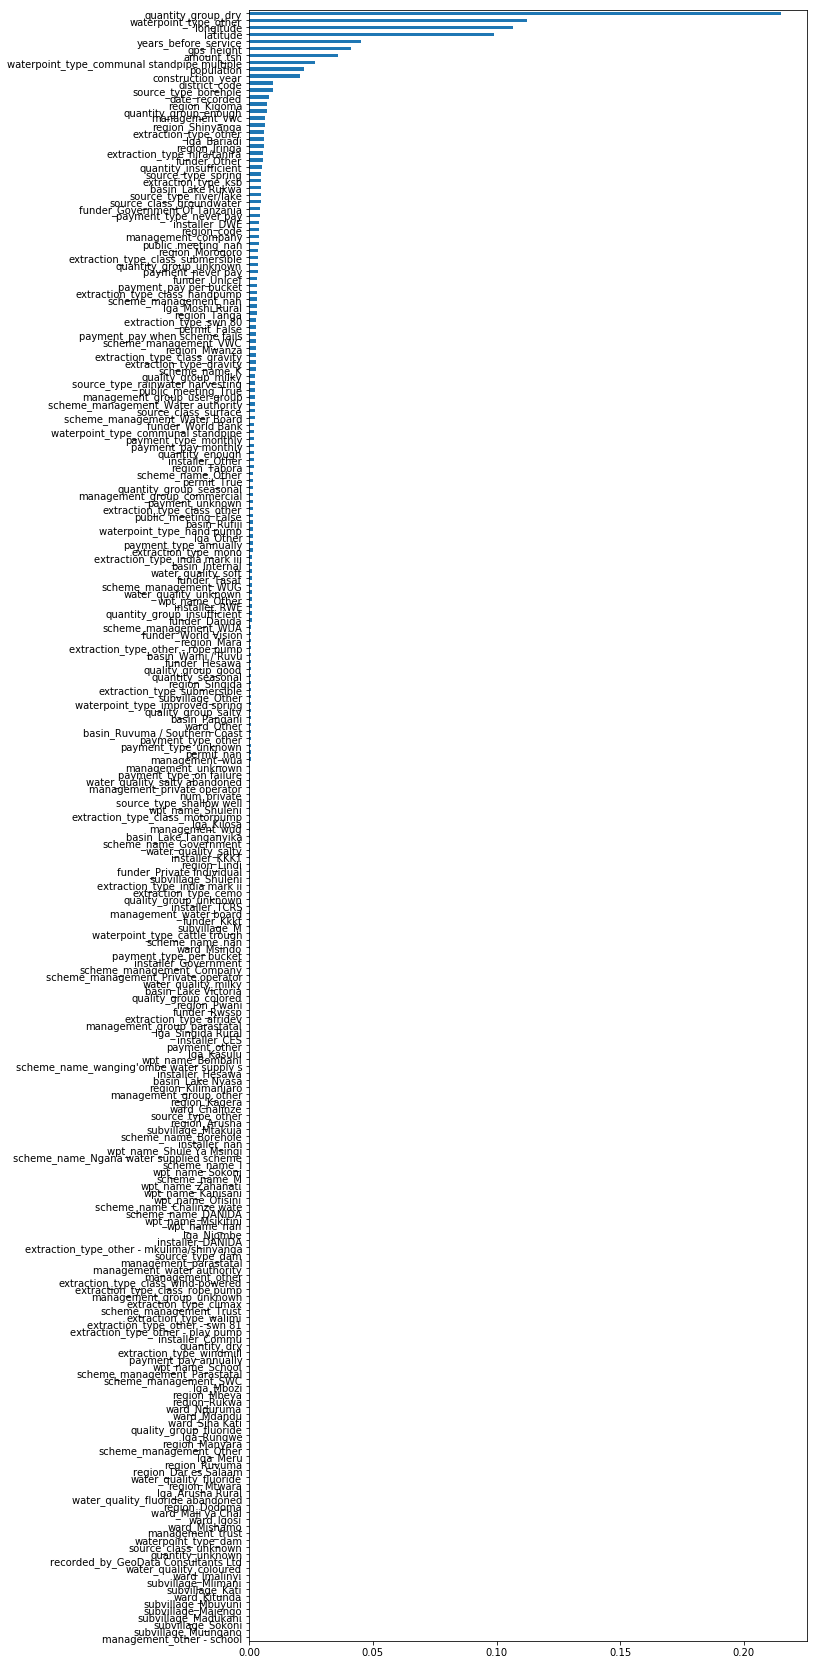

In [480]:
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()

In [443]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values(ascending=False)[:20].index.tolist()

['quantity_group_dry',
 'waterpoint_type_other',
 'longitude',
 'latitude',
 'years_before_service',
 'gps_height',
 'amount_tsh',
 'waterpoint_type_communal standpipe multiple',
 'population',
 'construction_year',
 'district_code',
 'source_type_borehole',
 'date_recorded',
 'region_Kigoma',
 'quantity_group_enough',
 'management_vwc',
 'region_Shinyanga',
 'extraction_type_other',
 'lga_Bariadi',
 'region_Iringa']

In [464]:
wrangled_train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source_type', 'source_class', 'waterpoint_type',
       'status_group', 'years_before_service'],
      dtype='object')

In [0]:
new_features = ['quantity_group', 'waterpoint_type', 'longitude', 'latitude', 'years_before_service', 'wpt_name', 'gps_height', 'amount_tsh']

In [0]:
X_train1 = wrangled_train[new_features]
X_val1 = wrangled_val[new_features]

y_train1 = wrangled_train[target]
y_val1 = wrangled_val[target]

In [503]:
index = range(0, 30)
isitgood = pd.DataFrame(index=index,columns=['Max Depth', 'Train Accuracy', 'Validation Accuracy'])

for i in range(1,30):
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(max_depth=i, random_state=42)
  )

  pipeline.fit(X_train1, y_train)
  isitgood['Max Depth'][i] = i
  isitgood['Train Accuracy'][i] = pipeline.score(X_train1, y_train)
  isitgood['Validation Accuracy'][i] = pipeline.score(X_val1, y_val)
  
isitgood

,Max Depth,Train Accuracy,Validation Accuracy
0,NaN,NaN,NaN
1,1,0.6411,0.645993
2,2,0.692503,0.69596
3,3,0.695758,0.695758
4,4,0.704242,0.706801
5,5,0.707901,0.709899
6,6,0.722222,0.720337
7,7,0.72716,0.724916
8,8,0.733423,0.726397
9,9,0.74092,0.73138


In [504]:
index = range(0, 30)
isitgood1 = pd.DataFrame(index=index,columns=['Min Sample', 'Train Accuracy', 'Validation Accuracy'])

for i in range(1,30):
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(min_samples_leaf=i, random_state=42)
  )

  pipeline.fit(X_train1, y_train)
  isitgood1['Min Sample'][i] = i
  isitgood1['Train Accuracy'][i] = pipeline.score(X_train1, y_train)
  isitgood1['Validation Accuracy'][i] = pipeline.score(X_val1, y_val)
  
isitgood1

,Min Sample,Train Accuracy,Validation Accuracy
0,NaN,NaN,NaN
1,1,0.991246,0.734074
2,2,0.925679,0.745589
3,3,0.900673,0.744916
4,4,0.878339,0.746397
5,5,0.865814,0.748215
6,6,0.85349,0.748889
7,7,0.84431,0.746936
8,8,0.836251,0.751785
9,9,0.829585,0.754074


# I DON'T LIKE THIS FUNCTION LET'S DO IT AGAIN

In [0]:
# Built from code from above, comments for each piece are above
def wrangler1(dataframe):

  x = dataframe.copy()
  
  # New Feature
  x['date_recorded'] = x['date_recorded'].str[:4].astype(int)
  x['years_before_service'] = x['date_recorded'] - x['construction_year']
  x.loc[(x['years_before_service']<0) | (x['years_before_service']>100), 'years_before_service'] = 0
  
  # Use code from earlier to reduce cardinality of some features
  # df = x.describe(exclude='number').T.sort_values(by='unique', ascending=False)[:10]
  # high_card = 50
  # high_card_features = df[df['unique'] >= high_card].T.columns.tolist()
  # for i in high_card_features:
  #   top15 = x[i].value_counts()[:10].index
  #   x.loc[~x[i].isin(top15), i] = 'Other'

  # Replace None, none, 0 with NaN values, and fix long/lat columns
  features_replace = ['scheme_name', 'installer', 'funder', 'wpt_name', 'longitude', 'latitude']
  x[features_replace] = x[features_replace].replace({'None':np.nan, 'none':np.nan, '0':np.nan, -2e-8:np.nan})
  
  # Drop duplicate and highly correlated features
  drops = ['extraction_type_group', 'waterpoint_type_group', 'source', 'quantity_group', 'id']
  x = x.drop(drops, axis=1)

  return x

In [0]:
wrangled_train1 = wrangler1(my_train)
wrangled_val1 = wrangler(my_val)

In [530]:
train_features = wrangled_train1.drop(target, axis=1)
numeric = train_features.select_dtypes(include='number').columns.tolist()
card = train_features.select_dtypes(exclude='number').nunique()
categorical = card[card <= 50].index.tolist()
feats = numeric + categorical
feats

['amount_tsh',
 'date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'years_before_service',
 'basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'source_type',
 'source_class',
 'waterpoint_type']

In [0]:
X_train_new = wrangled_train1[feats]
X_val_new = wrangled_val1[feats]

y_train_new = wrangled_train1[target]
y_val_new = wrangled_val1[target]

In [532]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train_new, y_train_new)
print(f'Train Accuracy: {pipeline.score(X_train_new, y_train_new)}')
print(f'Validation Accuracy: {pipeline.score(X_val_new, y_val_new)}')

Train Accuracy: 0.9960718294051627
Validation Accuracy: 0.7492929292929293


In [533]:
index = range(1, 30)
isitgood = pd.DataFrame(index=index,columns=['Max Depth', 'Train Accuracy', 'Validation Accuracy'])

for i in range(1,30):
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(max_depth=i, random_state=42)
  )

  pipeline.fit(X_train_new, y_train_new)
  isitgood['Max Depth'][i] = i
  isitgood['Train Accuracy'][i] = pipeline.score(X_train_new, y_train_new)
  isitgood['Validation Accuracy'][i] = pipeline.score(X_val_new, y_val_new)
  
isitgood

,Max Depth,Train Accuracy,Validation Accuracy
0,NaN,NaN,NaN
1,1,0.6411,0.645993
2,2,0.692503,0.69596
3,3,0.695758,0.695758
4,4,0.705926,0.708148
5,5,0.709428,0.712256
6,6,0.724242,0.721886
7,7,0.731111,0.725993
8,8,0.739798,0.732189
9,9,0.750079,0.735219


In [536]:
index = range(1, 30)
isitgood1 = pd.DataFrame(index=index,columns=['Min Sample', 'Train Accuracy', 'Validation Accuracy'])

for i in range(1,30):
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(min_samples_leaf=i, random_state=42)
  )

  pipeline.fit(X_train_new, y_train_new)
  isitgood1['Min Sample'][i] = i
  isitgood1['Train Accuracy'][i] = pipeline.score(X_train_new, y_train_new)
  isitgood1['Validation Accuracy'][i] = pipeline.score(X_val_new, y_val_new)
  
isitgood1

,Min Sample,Train Accuracy,Validation Accuracy
1,1,0.996072,0.749293
2,2,0.934658,0.758249
3,3,0.910101,0.755152
4,4,0.889136,0.757912
5,5,0.874411,0.757643
6,6,0.864108,0.759192
7,7,0.854523,0.762357
8,8,0.848126,0.76229
9,9,0.841706,0.765455
10,10,0.836902,0.766263


# Submission

In [538]:
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(max_depth=17, random_state=42)
  )

  pipeline.fit(X_train_new, y_train_new)
  print(f'Train Accuracy: {pipeline.score(X_train_new, y_train_new)}')
print(f'Validation Accuracy: {pipeline.score(X_val_new, y_val_new)}')

Train Accuracy: 0.8617732884399552
Validation Accuracy: 0.7708417508417509


In [0]:
wrangled_X_test = wrangler1(test)
X_test = wrangled_X_test[feats]

In [0]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('decision.csv', index=False)